# Regularization and overfitting

You may be surprised to learn that the goal of training a neural network is not to minimize the training loss.  This might seem counterintuitive.  We've been training models using gradient descent, where training loss decreases over time.

However, the training data is just a sample of the population data.  For example,we have data on house prices, where each row in this dataset represents a single house.  Here are the columns:

- `interest`: The interest rate
- `vacancy`: The vacancy rate
- `cpi`: The consumer price index
- `price`: The price of a house
- `value`: The value of a house
- `adj_price`: The price of a house, adjusted for inflation
- `adj_value`: The value of a house, adjusted for inflation

We have about `700` different rows of data - this is called our sample.  There are many more houses that aren't in our training data - this is called the population.  What we actually want to do is train the model on our sample of data, but use it to make predictions on the population.

If our model makes good predictions in our sample, but bad predictions in the population, then that's called overfitting.  Overfitting happens when the model learns random characteristics of our sample instead of the underlying characteristics of our population. For example, if the vacancy rate is always high before house prices drop in the sample, but not in the population, then this is a random quirk of our sample.

Overfitting means that the model won't be useful in the real world.  Neural networks are prone to overfitting, and there are many techniques that have been developed to prevent it.  These techniques are broadly called regularization, which adds constraints or penalties to the model's parameters, in order to encourage it to learn simpler and more generalizable representations.  These will usually increase loss in the sample, but decrease loss in the population.

Of course, we don't have access to data from the population.  This means that we need to split our sample up into a training set, a validation set, and a test set.  While we're training the model, we'll evaluate on the validation set.  After we've optimized our training method and parameters, we'll evaluate on the test set.  This ensures that we're not using knowledge of the test set when we tune our parameters (this could cause overfitting to the test set).

We'll learn three forms of regularization:

- Weight decay, which decreases the magnitude of the weights in the optimizer.  This pushes most of the weights towards zero, which encourages the model to learn simpler representations.
- Dropout, which randomly sets activations to zero.  This prevents the model from relying on any single activation, and encourages it to learn more generalizable representations.
- Early stopping, which stops training when the validation loss starts to increase.  This prevents overfitting by stopping training before the model starts to memorize the training data.

There are other forms of regularization, like data augmentation, but these are the most common when working with text.

At the end of this lesson, we'll also cover two techniques that can help with overfitting and convergence, but aren't strictly regularization techniques:

- Layer normalization - this technique normalizes the activations to have mean 0 and standard deviation 1, which reduces the magnitude of the values
- Residual connections - this is a "skip-layer" connection that sums that activations from the previous layer with the activations from the current layer

## Regularization

We'll first load in the data, which is the same from the last lesson:

In [1]:
import sys, os
sys.path.append(os.path.abspath('../data'))
sys.path.append(os.path.abspath('../nnets'))
from dense import DenseManualUpdate as Dense, forward, backward
from csv_data import HousePricesDatasetWrapper
import numpy as np
from optimizer import Optimizer

wrapper = HousePricesDatasetWrapper()
train_data, valid_data, test_data = wrapper.get_flat_datasets()

### Setting up a training run

As you can see, we split the data into three sets.  We'll use the training set to train the model, the validation set to evaluate the model, and the test set to evaluate the model after we've finished training.

We'll write a training loop function, which will allow us to test different types of regularization.  The function:

- Sets up a new W&B run for monitoring
- Loops through the training data with batch size 1:
    - Makes a prediction
    - Finds the error
    - Computes the gradient
    - Updates the parameters
- Logs the loss

We will again be using Weights & Biases (W&B) to log our training data and plot loss curves.  There is a nice web dashboard where you can see the results of each run.  If you don't want to sign up for a W&B account, you can leave the monitoring code out, but you will need to add in a way to print out the loss at each epoch.

In [2]:
# Initialize W&B
%env WANDB_SILENT=True

import wandb
wandb.login()

def training_run(epochs, regularization, layers, optimizer, train_data, valid_data, name=None):
    # Initialize a new W&B run
    wandb.init(project="regularization",
               name=name,
               config={"regularization": regularization})

    # Split the training and valid data into x and y
    train_x, train_y = train_data
    valid_x, valid_y = valid_data

    for epoch in range(epochs):
        running_loss = 0
        for i in range(len(train_x)):
            # Get the x and y batches
            x_batch = train_x[i:(i+1)]
            y_batch = train_y[i:(i+1)]
            # Make a prediction
            pred = forward(x_batch, layers, training=True)

            # Run the backward pass
            loss = pred - y_batch
            layer_grads = backward(loss, layers)
            running_loss += np.mean(loss ** 2)

            # Run the optimizer
            optimizer(layer_grads, layers, 1)

        # Calculate and log validation loss
        valid_preds = forward(valid_x, layers, training=False)
        valid_loss = np.mean((valid_preds - valid_y) ** 2)
        train_loss = running_loss / len(train_x)

        # Log training metrics
        wandb.log({
            "valid_loss": valid_loss,
            "epoch": epoch,
            "train_loss": train_loss,
        })

    # Mark the run as complete
    wandb.finish()

env: WANDB_SILENT=True


We'll also write a function to calculate test set loss.  This will help us evaluate different regularization models.

In [3]:
def test_loss(layers, test_data):
    test_x, test_y = test_data
    preds = forward(test_x, layers, training=False)
    loss = np.mean((preds - test_y) ** 2)
    return loss

### Weight decay

Weight decay is similar to L2 regularization.  The goal is to shrink the weights towards 0 (reduce the L2 norm of the weights).  This means that the model will be less likely to learn very large weights.  Very large weights can cause overfitting, because it means that the model is putting too much importance on a single value.

The difference between L2 regularization and weight decay is small, and has to do with where the weights are shrunk.  In SGD, they are the same, but this is not the case in other optimizers like SGD with momentum.  You can read more about the difference [here](https://arxiv.org/pdf/1711.05101.pdf).

As an example, let's look at the weights of a model with and without weight decay.  First, we'll define our SGDW optimizer.  This is SGD, but with weight decay.  The main addition is the line `w_update -= self.decay * layer.weights`.  This multiplies a decay coefficient (usually a number like `.01`) by the weights, then adds it to the weight update.  This will shrink the weights over time.

For example, if the decay coefficient is `.1`, and we ignore the gradient, then after the first update, the weights will be `90%` of their original magnitude, `81%` after the second update, and so on.  This means that the shrinkage will be proportional to the size of the weight.  So large weights will be reduced more in absolute terms.

Now, we can define the optimizer:

In [4]:
class SGDW(Optimizer):
    def __init__(self, lr, decay):
        # Store the learning rate and decay coefficient
        self.lr = lr
        self.decay = decay
        super().__init__()

    def __call__(self, layer_grads, layers, batch_size):
        # Loop through the layer grads.  Reverse the layers to match the grads (from output backward to input).
        for layer_grad, layer in zip(layer_grads, reversed(layers)):
            if layer_grad is None:
                # Account for dropout layers
                continue
            w_grad, b_grad = layer_grad

            # Calculate the gradient update size
            w_update = -self.lr * w_grad
            # Calculate weight decay
            w_update -= self.decay * layer.weights

            # We don't usually decay the bias
            b_update = -self.lr * b_grad

            # Actually do the update
            layer.update(w_update, b_update)

        self.save_vector(layers)

Now, we can look at an example without any weight decay.  If we set the decay coefficient to `0`, it's equivalent to plain SGD.  We'll define a two-layer neural network, then run our training loop.  We'll look at our final weights to check the distribution:

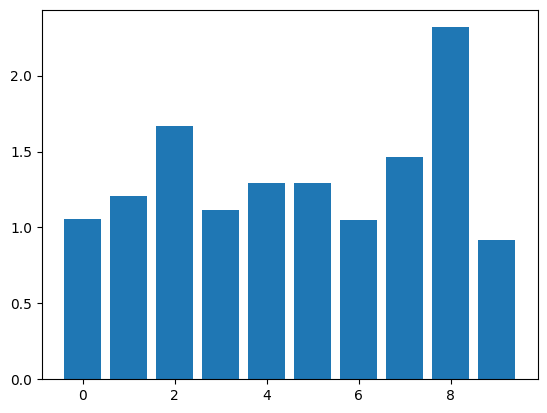

In [5]:
# Two-layer neural network
layers_sgd = [
    Dense(7, 10),
    Dense(10, 1, activation=False)
]
# No decay is equal to SGD
sgd = SGDW(1e-3, 0)
# Normal SGD
training_run(10, "None", layers_sgd, sgd, train_data, valid_data, name="sgd")

# Plot the final weights
sgd.plot_final_weights()

As you can see above, there are two larger weight values.

We can now do the same thing with weight decay.  We'll use a decay coefficient of `1e-3`.  You'll need to experiment with the learning rate and the decay coefficient.  Too large of a decay coefficient relative to the learning rate can prevent the model from learning.  Too small of a decay coefficient won't penalize the large weights.

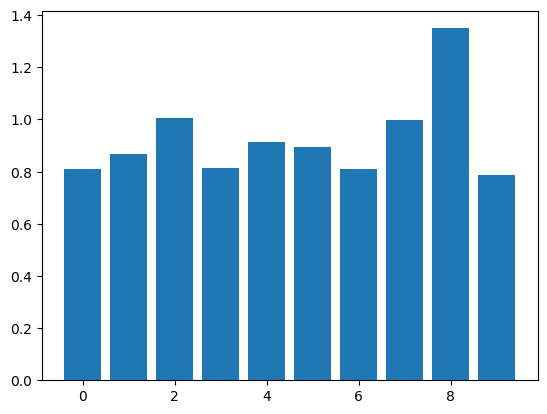

In [6]:
layers_sgdw = [
    Dense(7, 10),
    Dense(10, 1, activation=False)
]

# No decay is equal to SGD
sgd = SGDW(1e-3, 5e-4)
# Weight decay
training_run(10, "Weight Decay", layers_sgdw, sgd, train_data, valid_data, name="sgdw")
sgd.plot_final_weights()

As you can see, our weight values are closer together, and the largest values are now smaller.  This can help the network generalize better to new data.

In [7]:
print(f"SGD: {test_loss(layers_sgd, test_data)}")
print(f"SGDW: {test_loss(layers_sgdw, test_data)}")

SGD: 28.325657408857865
SGDW: 107.32555507049128


In this case, our test set loss is higher with weight decay than without it.  Weight decay won't always reduce test set loss - it depends on how similar the training and test set are, as well as other characteristics of the data.

### Dropout

Dropout is a regularization technique that randomly sets some activations in the network to zero.  We add in dropout right after the activation function:

![](images/regularization/network_dropout.svg)

A dropout layer will randomly set some inputs to zero.  The layer takes one parameter, which is the probability that any single value will be set to `0`.  This is usually called `p` or `drop_p`.

Here is an example:

![](images/regularization/dropout.svg)

In this example, the dropout layer sets a single activation to 0, based on the probability of `.5`.

You might be wondering what the point of this is - it seems like it just throws away valuable inputs.  Dropout forces the network to make predictions with a subset of the full network.  This means that the network is more robust to noisy input or other issues. It can even be thought of as a form of ensembling, where multiple smaller models are combined into a larger, more powerful one.

Here's another look at the same operations from before:

![](images/regularization/ensemble_network.svg)

As you can see, in the example with dropout, predictions are made by a subset of the network.  If we repeatedly apply dropout, we force the network to become more resilient, and minimize overfitting.

Just as important as when we apply dropout is when we don't apply it.  We don't apply dropout after the final output layer. This will result in many of our predictions being zero, which isn't what we want.  We also don't use dropout directly on the inputs. We basically only want to use dropout inside the network, to force the network to use a subset to make the predictions.

We also only use dropout in training, not in inference.  In inference, using dropout will result in lower accuracy without any gains (the gain is in training the network to be more resilient).

We can define a dropout layer that we can then use in our network.  The layer will be relatively straightforward:

- We'll set a `drop_p`, which is the probability that we'll drop out (set to 0) any single value.
- In the forward pass, we'll randomly set some values to 0.
- In the backward pass, we'll set the gradient to zero where we applied dropout.  Similarly to Relu, when we zero out a value, it doesn't contribute to the prediction (and loss), so we don't want to use it in the backward pass.

In [8]:
class Dropout():
    def __init__(self, drop_p):
        # Probability that we'll drop out any single input
        self.drop_p = drop_p
        self.training = True

    def forward(self, input):
        if self.training:
            # Generate a mask of 0s and 1s, using the drop probability
            self.mask = np.random.binomial(1, 1-self.drop_p, input.shape)
        else:
            # No dropout in inference
            self.mask = np.ones_like(input)
        # Apply the mask.  If the mask is 0, the input is set to 0
        return np.where(self.mask, input, 0)

    def backward(self, grad):
        # Use np.where to zero out the gradient where we did dropout
        return None, np.where(self.mask, grad, 0)

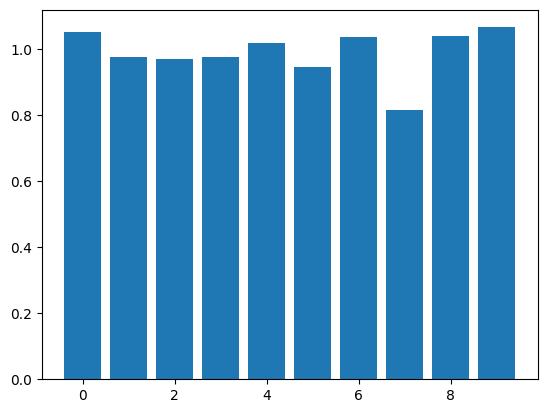

In [9]:
layers_dropout = [
    Dense(7, 10),
    Dropout(.2),
    Dense(10, 1, activation=False)
]

sgd = SGDW(1e-3, 5e-4)
# Weight decay and dropout
training_run(10, "Weight Decay + Dropout", layers_dropout, sgd, train_data, valid_data, name="dropout")
sgd.plot_final_weights()

In [10]:
print(f"SGDW: {test_loss(layers_sgdw, test_data)}")
print(f"SGDW + Dropout: {test_loss(layers_dropout, test_data)}")

SGDW: 107.32555507049128
SGDW + Dropout: 13.244365053084687


As you can see, combining SGDW and dropout worked effectively to prevent overfitting.  I would encourage you to play around with the drop probability, and look at the loss in the W&B dashboard.

### Early Stopping

Early stopping can prevent overfitting by stopping training when the validation loss is plateauing or increasing.  It's the simplest form of regularization, but can also be the most powerful.

The straightforward way to do early stopping is to watch the validation loss, then stop training as soon as you observe it increasing.  You may need to "rewind" an epoch or two to get back to before the loss started to increase.  It's common to save checkpoints regularly while training, and then choose the best one after observing the loss.

![](images/regularization/early_stopping.png)

In the example, above, we'd want to stop training after epoch 5.


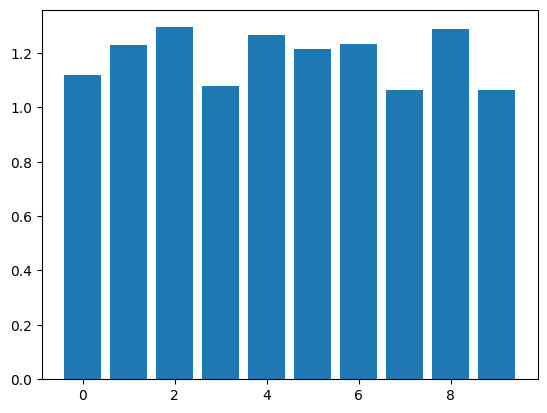

In [11]:
layers_early = [
    Dense(7, 10),
    Dropout(.2),
    Dense(10, 1, activation=False)
]

sgd = SGDW(1e-3, 5e-4)
# Weight decay and dropout
training_run(4, "Early Stopping", layers_early, sgd, train_data, valid_data, name="early_stopping")
sgd.plot_final_weights()

In [12]:
print(f"SGDW + Dropout: {test_loss(layers_dropout, test_data)}")
print(f"SGDW + Dropout + Early Stopping: {test_loss(layers_early, test_data)}")

SGDW + Dropout: 13.244365053084687
SGDW + Dropout + Early Stopping: 15.488170569363843


In this case, adding in early stopping doesn't improve test set accuracy, but it does get similar accuracy with less than half the epochs.  When you're training larger models, a single epoch can take days or weeks, and saving time is important.

## Training convergence

We'll now explore some techniques that aren't strictly regularization, but can help with training stability, convergence, and overfitting.

When you're training deep neural networks with many layers, it's common for gradients to vanish/explode (get very small or very large) due to the sheer number of matrix multiplications.  If you multiply a number by another number between `0` and `1` repeatedly, it will get very small.  If you multiply a number by another number greater than `1` repeatedly, it will get very large.

We discussed this in a slightly different context in the lesson on RNNs.  This can cause the network to become unstable - loss will increase or decrease wildly from epoch to epoch.  Ideally, we'd have a nice smoothly descending loss curve, like this one:

![](images/regularization/smooth_descent.png)

Unstable loss curves, with spikes, can result in training where the loss ends up increasing (training never converges), or bad predictions.  Here's an example of loss spikes in training:

![](images/regularization/loss_spikes.png)


A smoothly descending loss curve with no spikes is one that is stable and converging well.

### Residual connections

One technique that can help with stable convergence is called residual connection.  Residual connections add the output of the last layer to the output of the current layer.  This helps gradients "flow" through large networks better.

![](images/regularization/residual_gradient.svg)

As you can see, the backward gradient flows from the output to both the previous layer, and the layer before that.  This can help with the vanishing gradient problem (because the residual flow is not altered by any operations).

 Read more about residual connections [here](https://arxiv.org/pdf/1512.03385v1.pdf).

First, we'll create a layer that has a residual connection.  It will add in the output from the previous layer to the current layer output.  It will do something similar in the backward pass by summing the incoming gradient with the output gradient.

Note that in order to use a residual connection, the gradients for both layers need to be the same size.  This means that the output of the layers should have the same shape (same number of columns).  We'll add another layer, so we can have two layers with the same output shape.

In [13]:
class DenseResidualConnection(Dense):
    """
    Dense layer with a residual connection
    """
    def forward(self, x):
        output = super().forward(x)
        return x + output # Sum input with output

    def backward(self, grad):
        param_grads, out_grad = super().backward(grad)
        # Sum incoming gradient with calculated gradient
        return param_grads, grad + out_grad

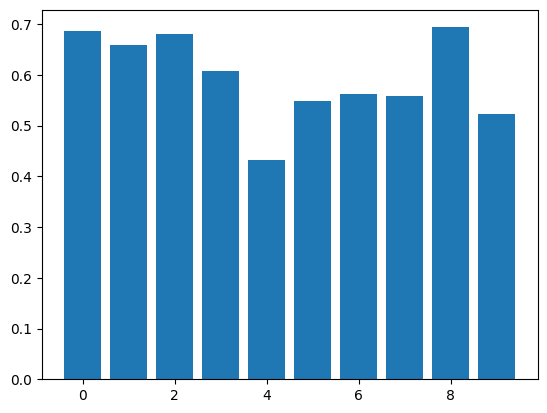

In [14]:
layers_resid = [
    Dense(7, 10),
    DenseResidualConnection(10, 10),
    Dropout(.2),
    Dense(10, 1, activation=False)
]

sgd = SGDW(1e-4, 5e-4)
# Weight decay and dropout
training_run(10, "Residual Connection", layers_resid, sgd, train_data, valid_data, name="residual_connection")
sgd.plot_final_weights()

In [15]:
print(f"SGDW + Dropout + Early Stopping: {test_loss(layers_early, test_data)}")
print(f"Residual Connection: {test_loss(layers_resid, test_data)}")

SGDW + Dropout + Early Stopping: 15.488170569363843
Residual Connection: 26.43739286149877


One of the issues with residual connections is that they increase the size of the activations.  With many layers (a deep network can have hundreds of layers), we'll essentially double the activations each time we have a residual connection.  This can quickly make the values explode.

We can fix this by using a technique called layer normalization.  Residual connections and layer normalization are often used together, including in transformers.

# Layernorm

Layer normalization (or layernorm) will normalize the values in a layer by subtracting the mean and dividing by standard deviation:

\begin{equation}
\mathbf{y}_i = \frac{\mathbf{x}_i - \mu_i}{\sqrt{\sigma_i^2 + \epsilon}} * \gamma + \beta
\end{equation}

The mean and standard deviation are calculated for each row of data.  The $\gamma$ and $\beta$ parameters scale the data, similarly to weights and biases.  The goal of these parameters is to ensure that the model can learn the optimal range for the values.  However, using them is becoming less common, as subsequent layers can rescale the values.  We'll leave off $\gamma$ and $\beta$ in our implementation.

The purpose of layernorm is to ensure that values stay in a tighter range around 0 during training.  This enables using higher learning rates, and reduces the chance of loss spikes and other training instability.

If you haven't looked at the previous lesson on the [computational graph](https://github.com/VikParuchuri/zero_to_gpt/blob/master/explanations/comp_graph.ipynb), I recommend doing so before looking at the LayerNorm implementation.  It will make understanding the backward pass of the LayerNorm much easier.

Here is the computational graph for the forward pass of LayerNorm:

![](images/regularization/layernorm_steps_full.svg)

We'll implement this in code, then reverse it to get the backward pass.  There's a lot going on in this graph.  It's much more complex than you might think, so I'd recommend looking at the computational graph lesson, and working through the backward pass yourself.

In [16]:
class LayerNorm():
    def __init__(self, embed_dim, eps):
        self.embed_dim = embed_dim
        # eps is a parameter added for numerical stability when taking a square root
        self.eps = eps

    def forward(self, input):
        # Cache for backward pass
        self.input = input
        # Calculate the mean and standard deviation
        self.mean = np.sum(input, axis=1, keepdims=True) / self.embed_dim
        self.normed = (input - self.mean)
        variance = np.sum(self.normed**2, axis=1, keepdims=True) / self.embed_dim
        self.std = np.sqrt(variance + self.eps)
        inverse_std = 1 / self.std
        # Normalize the input
        self.output = self.normed * inverse_std
        return self.output

    def backward(self, grad):
        """
        This is a long function, but it is just "undoing" the forward pass
        """
        # Find the derivative of numerator (normed)
        # Grad times inverse standard deviation
        grad_normed_1 = grad * 1 / self.std

        # Derivative of denominator (std)
        grad_std = grad * self.normed
        # std is a single number
        grad_std = np.sum(grad_std, axis=1, keepdims=True)
        # Derivative of 1 / std
        grad_std = grad_std * -1 / (self.std**2)

        # Find gradient against the variance
        grad_variance = grad_std * .5 * 1 / self.std

        # Find gradient against normed
        grad_normed_2 = grad_variance * 1 / self.embed_dim
        grad_normed_2 = np.ones_like(self.normed, dtype=self.input.dtype) * grad_normed_2
        grad_normed_2 = grad_normed_2 * 2 * self.normed

        # Combine two gradients against normed
        grad_normed = grad_normed_1 + grad_normed_2

        # Find gradient against mean
        grad_mean = grad_normed * -1
        grad_mean = np.sum(grad_mean, axis=1, keepdims=True)

        # Find gradient against input
        grad_input_1 = grad_normed
        grad_input_2 =  grad_mean * 1 / self.embed_dim
        grad_input_2 = grad_input_2 * np.ones_like(self.input, dtype=self.input.dtype)

        # Combine two gradients against input
        grad_input = grad_input_1 + grad_input_2
        return None, grad_input

As a comparison, we can implement a version of the backward pass that comes from a derivation of the LayerNorm formula.  Reversing the computational graph takes more code, but is easier to trace and understand if you don't have a math background.  Both methods should give us the same answer.

In [17]:
class LayerNormAnalytic(LayerNorm):
    def backward(self, grad):
        y_sum = np.sum(grad, axis=1, keepdims=True)
        N = 1 / self.embed_dim
        c1 = N * np.sum(self.output * grad, axis=1, keepdims=True)
        c2 = N * y_sum
        return None, 1/self.std * (grad - c1 * self.output - c2)

Now, we can test our layernorm implementation to see if it improves convergence.

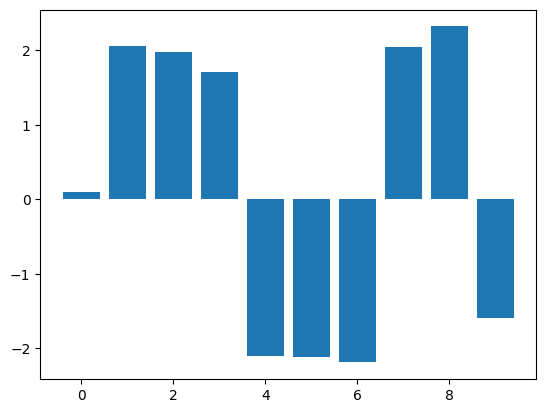

In [18]:
layers_ln = [
    Dense(7, 10),
    DenseResidualConnection(10, 10),
    LayerNorm(10, 1e-6),
    Dropout(.2),
    Dense(10, 1, activation=False)
]

sgd = SGDW(1e-3, 1e-4)
# Weight decay and dropout
training_run(25, "Layer Norm", layers_ln, sgd, train_data, valid_data, name="layer_norm")
sgd.plot_final_weights()

In [19]:
print(f"SGDW + Residual Connection: {test_loss(layers_resid, test_data)}")
print(f"SGDW + Residual Connection + LayerNorm: {test_loss(layers_ln, test_data)}")

SGDW + Residual Connection: 26.43739286149877
SGDW + Residual Connection + LayerNorm: 433.9127938623826


If you check the W&B dashboard, you should see that the loss curve appears smoother now:

![](images/regularization/layer_norm.png)

Of course, the test set loss is much higher with layer normalization than without it.  We could experiment with different learning rates and other parameters to try to fix this.  For example, a learning rate of `1e-3` results in lower training loss than other techniques:

![](images/regularization/layer_norm_high_lr.png)

Layer normalization enables us to use a higher learning rate, especially when combined with residual connections.  This can make training convergence faster, but is not guaranteed to increase test and validation set accuracy.  It can take a lot of experimentation to find the right set of layers and parameters to optimize test set accuracy.

## Wrap-up

We've covered several building blocks that will help you reduce overfitting and improve convergence in deep neural networks.  I'd recommend experimenting with these techniques while adding in more layers to see what they do in a very deep network.

We now have most of the building blocks necessary to create a transformer layer.  Transformers are the models that have powered many recent advanced in AI, like LLMs.  In the next couple of lessons, we'll learn about PyTorch and how to work with text in PyTorch.  Then, we'll replicate the original transformers paper!